In [53]:
# Imported required packages
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List
from tqdm import tqdm

import math
import random
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt


# Setting plot size, plot style & random seed
plt.rcParams["figure.figsize"] = (15,15)
plt.style.use('ggplot')
random.seed(1)

In [20]:
class BanditAlgorithm(ABC):
    """
    Abstract class to capture common behaviours among different types of bandit algorithms.
    
    select_arm will depend on specific bandit algorithm and is left as an abstract method.
    """
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        """
        Method to set counts & values if previously not initialised
        
        :param n_arms: Number of arms in the simulation
        :return: Self
        """
        self.counts: List[int] = [0 for arm in range(n_arms)]
        self.values: List[float] = [0.0 for arm in range(n_arms)]
        return self
    
    @abstractmethod
    def select_arm(self) -> int:
        """
        Method to select arm
        
        :return: Index of chosen arm
        """
        pass
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        """
        Method to update counts & values after choosing an arm and obtaining a reward
        
        :param chosen_arm: Index of chosen arm
        :param reward: Reward earned from arm
        :return: Self
        """
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        new_value = (((n - 1) / float(n)) * value) + ((1 / float(n)) * reward)
        self.values[chosen_arm] = new_value
        return self
    
    def __str__(self) -> str:
        # Return name of algorithm, for plotting graphs
        return self.__class__.__name__                                    

In [21]:
class EpsilonGreedy(BanditAlgorithm):
    """
    Epsilon-Greedy bandit algorithm
    """
    
    def __init__(self, epsilon: float = 0.1) -> None:
        # Default epsilon is 0.1
        self.epsilon = epsilon
        return
    
    def select_arm(self) -> int:
        # Observe if this step will be exploration or exploitation
        if random.random() > self.epsilon:
            # If exploit, select best arm
            m = max(self.values)
            return self.values.index(m)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))
    
    def __str__(self) -> str:
        return f"Epsilon-Greedy with Epsilon={self.epsilon}"

In [22]:
class EpsilonDecay(BanditAlgorithm):
    """
    Epsilon-Decay bandit algorithm
    """
    
    def select_arm(self) -> int:
        
        # Calculate epsilon
        epsilon = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Observe if this step will be exploration or exploitation
        if random.random() > epsilon:
            # If exploit, select best arm
            m = max(self.values)
            return self.values.index(m)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))

In [23]:
class Softmax(BanditAlgorithm):
    """
    Softmax bandit algorithm
    """
    
    def __init__(self, tau: float = 0.1) -> None:
        # Default temperature is 0.1
        self.tau = tau
        return
    
    def select_arm(self) -> int:
        # Calcualte proability
        z = sum([math.exp(v / self.tau) for v in self.values])
        pi = [math.exp(v / self.tau) / z for v in self.values]
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice
    
    def __str__(self) -> str:
        return f"Softmax with Temperature={self.tau}"

In [24]:
class AnnealingSoftmax(BanditAlgorithm):
    """
    Annealing softmax bandit algorithm
    """
    
    def select_arm(self) -> int:
        
        # Calculate temperature
        tau = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Calcualte proability
        z = sum([math.exp(v / tau) for v in self.values])
        pi = [math.exp(v / tau) / z for v in self.values]
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice

In [25]:
class UCB(BanditAlgorithm):
    """
    Upper confidence bound bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Ensure that each arm has been played at least once
        for arm, count in enumerate(self.counts):
            if count == 0:
                return arm
        
        # Calculate the ucb of each arm
        ucb_values = [value for value in self.values]
        total_count = sum(self.counts)
        for arm in range(len(self.values)):
            # Calculate curiousity bonus which allows for exploration
            bonus = math.sqrt(
                (2 * math.log(total_count))
                / (float(self.counts[arm]))
            )
            ucb_values[arm] += bonus
        
        # Return arm with highest ucb
        return ucb_values.index(max(ucb_values))

In [26]:
class BetaBandit(BanditAlgorithm):
    """
    Abstract bandit algorithm class for BayesianUCB & Thompson Sampling, both utilise Beta distribution for prior distribution
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 , stdnum: float = 3.0
                 ) -> None:
        super().__init__()
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta
        return
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        self.alphas = [self.prior_alpha] * n_arms
        self.betas = [self.prior_beta] * n_arms
        super().set_arms(n_arms)
        return
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        # Updating counts & values
        super().update(chosen_arm, reward)
        # Updating alphas & betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1 - reward)
        return self

In [27]:
class BayesianUCB(BetaBandit):
    """
    Bayesian upper confidence bound bandit algorithm
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 , stdnum: float = 3.0
                 ) -> None:
        super().__init__(prior_alpha, prior_beta)
        self.stdnum = stdnum
        return
    
    def select_arm(self) -> int:
        # Calculate the ucb of each arm
        ucb_values = [0.0 for arm in self.values]
        for arm in range(len(self.values)):
            # Calculate mean of beta distribution
            expected_reward = self.alphas[arm] / float(self.alphas[arm] + self.betas[arm])
            # Calculate curiousity bonus which allows for exploration
            bonus = beta.std(self.alphas[arm], self.betas[arm]) * self.stdnum
            ucb_values[arm] = expected_reward + bonus
        
        # Return arm with highest ucb
        return ucb_values.index(max(ucb_values))

In [28]:
class ThompsonSampling(BetaBandit):
    """
    Thompson sampling bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate theta values for each arm
        theta_values = [0.0 for arm in self.values]
        for arm in range(len(self.values)):
            # Sample from beta distribution
            theta_values[arm] = np.random.beta(self.alphas[arm], self.betas[arm])
        
        # Return arm with highest theta
        return theta_values.index(max(theta_values))

In [29]:
class ContextualBandit(BanditAlgorithm):
    """
    Abstract class for contextual bandits
    """
    pass

In [30]:
class LinUCB(ContextualBandit):
    """
    Linear UCB contextual bandit algorithm
    """
    
    def set_arms(self
                 , n_arms: int
                 , n_features: int
                 , alpha: float = 0.1) -> BanditAlgorithm:
        self.alpha = alpha
        self.n_features = n_features
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros(n_features) for _ in range(n_arms)]
        return
    
    def select_arm(self, context: np.ndarray) -> int:
        # Initialise scores
        scores = np.zeros(len(self.A))
        for arm in range(len(self.A)):
            # Calculate score for each arm
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            p_arm = ((theta.transpose() @ context) 
                     + (self.alpha 
                        * np.sqrt(context.transpose() @ A_inv @ context))
            )
            scores[arm] = p_arm
        return np.argmax(scores)
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        self.A[chosen_arm] += np.outer(context, context)
        self.b[chosen_arm] += reward * context
        return self

In [31]:
def evaluation_replay(
    algos: List[BanditAlgorithm]
    , data: pd.DataFrame
    ) -> pd.DataFrame:
    """
    Function to perform evaluation replay with multiple bandit algorithms, including contextual bandits
    
    Results will contain policy, reward, cumulative reward for each time step
    
    :param algos: List of bandit algorithms to run
    :param data: DataFrame with 'business_id' as arm, 'stars' as reward
    :return: DataFrame containg results
    """
    
    # Count number of reviews
    n = data.shape[0]
    # Count number of arms
    n_arms = data['business_id'].nunique()
    results = []
    # Excluding all non-context columns
    context_df = data[data.columns[~data.columns.isin([
        'review_id'
        , 'user_id'
        , 'business_id'
        , 'stars'
        , 'date'
        , 'text'
        , 'useful'
        , 'funny'
        , 'cool'
    ])]]
    # Count number of features
    n_features = context_df.shape[1]
    
    # Note that bandit algorithms use arm as indexes, so we need to factorize 'business_id' into integer keys
    arm_id_series, business_id_order = pd.factorize(data['business_id'])
    data['arm_id'] = arm_id_series
    
    # Randomly shuffle data, as original data was in sequence of business_id
    data = data.sample(frac=1).reset_index(drop=True)
    
    for algo in algos:
        # Initialising arms
        if isinstance(algo, ContextualBandit):
            algo.set_arms(n_arms, n_features)
        else:
            algo.set_arms(n_arms)
        
        cumulative_reward = 0.0
        for t in tqdm(range(n), desc=f'Running {str(algo)}'):
            # Extract context at current time step
            context = context_df.iloc[t].to_numpy()
            
            # Draw arm
            if isinstance(algo, ContextualBandit):
                chosen_arm = algo.select_arm(context)
            else:
                chosen_arm = algo.select_arm()
            
            # Compare to actual arm
            actual_arm = data.iloc[t]['arm_id']
            if chosen_arm == actual_arm:
                # Update algorithm with reward if chosen arm matches actual arm
                reward = data.iloc[t]['stars']
                if isinstance(algo, ContextualBandit):
                    algo.update(chosen_arm, reward, context)
                else:
                    algo.update(chosen_arm, reward)
                
                # Updating cumulative reward
                cumulative_reward += reward
                
                # Appending results at current step
                current_step = {
                    'policy': str(algo),
                    'time_step': t,
                    'business_id': data.iloc[t]['business_id'],
                    'reward': reward,
                    'cumulative_reward': cumulative_reward
                }
                results.append(current_step)
    
    return pd.DataFrame(results)
                

In [51]:
def present_results(data: pd.DataFrame, target_metric: str) -> None:
    """
    Helper function to plot results, x-axis will be time_step
    
    :param data: DataFrame containg results of simulation
    :param target_metric: Metric to plot on y-axis
    """
    fig, ax = plt.subplots()
    # Set of colors for plot labels
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'blueviolet', 'lime']
    
    # Collect names of algorithm
    algo_names = data['policy'].unique().tolist()
    for i, algo_name in enumerate(algo_names):      
        
        # Filter results for that algorithm
        algo_result = data[data['policy'] == algo_name]
        ax.plot(
            algo_result['time_step']
            , algo_result[target_metric]
            , label=algo_name
            , color=colors[i])
    plt.legend()
    plt.title(f"{target_metric} at each step")

In [33]:
data = pd.read_csv('lasvegas_reviews.csv')
print(data.shape)
data.head()

(246483, 29)


,Unnamed: 0,review_id,user_id,business_id,date,text,useful,funny,cool,BusinessAcceptsCreditCards,...,BestNights_monday,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_breakfast,GoodForMeal_brunch,CoatCheck,DriveThru,DogsAllowed,stars
0,0,gN6GARS_BRr5UX2D3WAH0w,nOTl4aPC4tKHK35T3bNauQ,xVEtGucSRLk5pxxN0t4i6g,2012-08-23,We got recommendations for this place from my ...,0,0,0,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,1
1,1,Qnc2zkr-ld9nDJTzXmc4WQ,C_CYs2G3UFPng3MupCe5eQ,xVEtGucSRLk5pxxN0t4i6g,2015-04-06,"I really wanted to love this place, but I just...",1,1,1,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,0
2,2,qicHEB75WFOr9d8LNHqE8Q,l0-VQ8nA_oijpKlRB7dkow,xVEtGucSRLk5pxxN0t4i6g,2010-02-11,A beautiful restaurant that you would expect t...,1,0,0,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,1
3,3,4rppwJJ15o7LcjxEARRcfA,APdqZ02n-0L0jKpQ9hn-BA,xVEtGucSRLk5pxxN0t4i6g,2016-06-27,"Enjoyed our food, flavorful. We had Creamed sp...",0,0,0,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,1
4,4,FqKmtB_jZPYDM9Bzx4PZEQ,DQYMtGFO1-DUGB0yX3a4Qg,xVEtGucSRLk5pxxN0t4i6g,2010-03-15,My husband (fiance at the time) had our last m...,0,0,0,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,1


In [34]:
test_df = data[['review_id', 'business_id', 'stars']]
test_df['fakefeature1'] = np.random.randint(0, 2, test_df.shape[0])
test_df['fakefeature2'] = np.random.randint(0, 2, test_df.shape[0])

C:\Users\alif8\AppData\Local\Temp\ipykernel_1964\1272042712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['fakefeature1'] = np.random.randint(0, 2, test_df.shape[0])
C:\Users\alif8\AppData\Local\Temp\ipykernel_1964\1272042712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['fakefeature2'] = np.random.randint(0, 2, test_df.shape[0])


In [35]:
algos = [
    EpsilonGreedy(epsilon=0.1)
    , EpsilonDecay()
    , Softmax(tau=0.1)
    , AnnealingSoftmax()
    , UCB()
    , BayesianUCB()
    , ThompsonSampling()
    , LinUCB()
 ]
results = evaluation_replay(algos, test_df)

C:\Users\alif8\AppData\Local\Temp\ipykernel_1964\438775068.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['arm_id'] = arm_id_series
Running LinUCB: 100%|██████████| 246483/246483 [20:10<00:00, 203.69it/s] 


In [36]:
results

,policy,time_step,business_id,reward,cumulative_reward
0,Epsilon-Greedy with Epsilon=0.1,0,xVEtGucSRLk5pxxN0t4i6g,1,1.0
1,Epsilon-Greedy with Epsilon=0.1,1,xVEtGucSRLk5pxxN0t4i6g,0,1.0
2,Epsilon-Greedy with Epsilon=0.1,2,xVEtGucSRLk5pxxN0t4i6g,1,2.0
3,Epsilon-Greedy with Epsilon=0.1,3,xVEtGucSRLk5pxxN0t4i6g,1,3.0
4,Epsilon-Greedy with Epsilon=0.1,4,xVEtGucSRLk5pxxN0t4i6g,1,4.0
...,...,...,...,...,...
16106,LinUCB,1544,xVEtGucSRLk5pxxN0t4i6g,0,1167.0
16107,LinUCB,1545,xVEtGucSRLk5pxxN0t4i6g,0,1167.0
16108,LinUCB,1546,xVEtGucSRLk5pxxN0t4i6g,0,1167.0
16109,LinUCB,1547,xVEtGucSRLk5pxxN0t4i6g,0,1167.0


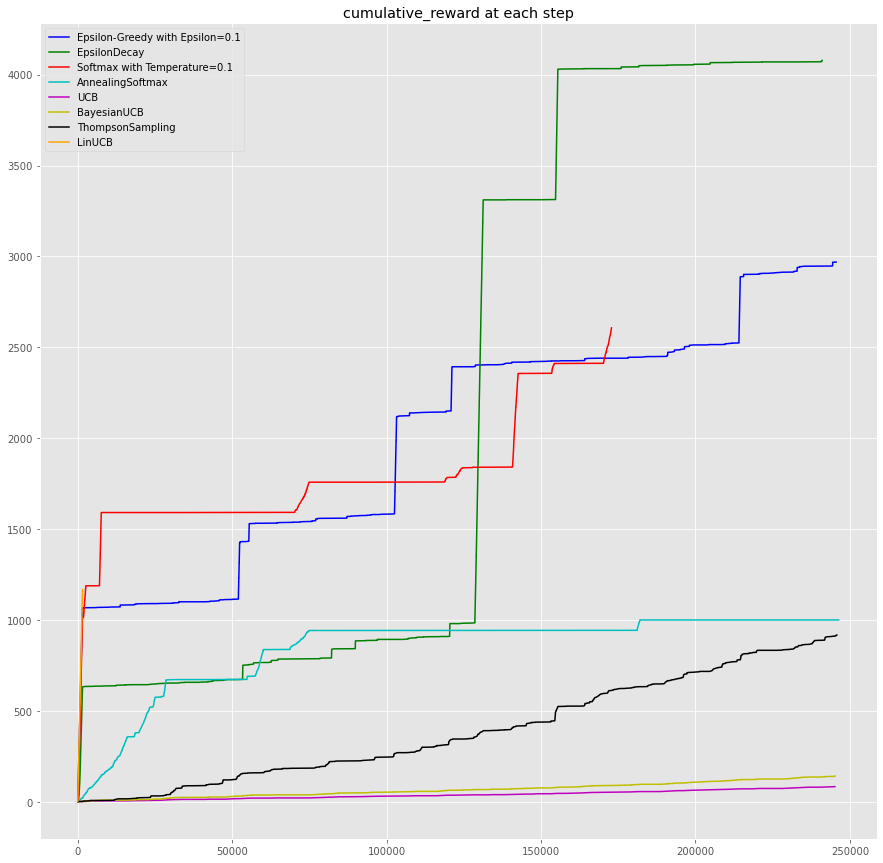

In [54]:
present_results(results, 'cumulative_reward')